In [198]:
#Tables and matrices
import numpy as np
import pandas as pd

#Stats
import scipy.stats as st
from scipy.optimize import fmin
from scipy import integrate
from scipy.stats.mstats import mquantiles
import statsmodels.formula.api as smf
import statsmodels.api as sm 
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler
from patsy import dmatrix
from mlxtend.feature_selection import SequentialFeatureSelector

#Probabilistic programs
#!pip install numpy mkl #if you are in an intel machine i.e. in mac M# chips no
#!pip install pymc
#!pip install pytensor
import pymc as pm
import pytensor.tensor as pt
#import aesara.tensor as at
print('Running on PyMC v{}'.format(pm.__version__))


#Graphs 
#IMPORTANT: properly install ipywidgets and nodejs for interactive graphs
#If you are in jupyterlab, activate the widget extension (it should be in the latest versions)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from matplotlib import animation, rc
from IPython.display import display, HTML, Markdown
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox, Layout
from mpl_toolkits.mplot3d import axes3d
import arviz as az

#Regular expressions
import re

Running on PyMC v5.10.3


# Forward selection

We start with this technique but this is a merely explorative technique. See all the drawbacks in the pdf slides.

In [208]:
Hitters = pd.read_csv("Hitters.csv")
Hitters = Hitters.dropna().reset_index(drop=True)
non_cat_cols = np.append(np.array(Hitters.columns[0:13]), Hitters.columns[15:19]) #numerical columns
Hitters.loc[:, non_cat_cols] = st.zscore(Hitters.loc[:, non_cat_cols])


In [209]:
Hitters.loc[:, non_cat_cols].mean()

AtBat      1.013131e-17
Hits       5.741077e-17
HmRun      3.377104e-17
Runs      -5.065656e-17
RBI        1.215758e-16
Walks      1.688552e-18
Years     -5.403367e-17
CAtBat     6.078788e-17
CHits      6.754209e-17
CHmRun     5.403367e-17
CRuns      3.377104e-17
CRBI       4.052525e-17
CWalks     1.080673e-16
PutOuts    7.429629e-17
Assists    0.000000e+00
Errors     1.046902e-16
Salary     1.485926e-16
dtype: float64

In [211]:
#We want to predict the salary of a baseball player
#Load data
Hitters = pd.read_csv("Hitters.csv")
Hitters = Hitters.dropna().reset_index(drop=True)
non_cat_cols = np.append(np.array(Hitters.columns[0:13]), Hitters.columns[15:19]) #numerical columns
Hitters.loc[:, non_cat_cols] = st.zscore(Hitters.loc[:, non_cat_cols]) #center numerical variables

#Dummy coding of categorical data
League_l = ['N','A'] #first element will be the reference 0
Div_l = ['E', 'W']
dm = dmatrix("~ 1 + C(League, levels=League_l) + C(Division, levels=Div_l) + C(NewLeague, levels=League_l)", 
             Hitters) #Dummy coding of categorical variables
print(dm.design_info.column_names) #to change manually to more readable names

#Concatenate dummy coded variables with non-categorical variables
Hitters_d = pd.concat([pd.DataFrame(dm, columns=["Intercept", "League_1_American", "Division_1_West", "New_League_1_American"]), 
                       Hitters.loc[:, non_cat_cols]], axis = 1)
Hitters_d.drop(columns=['Intercept'], inplace = True)
print(Hitters_d.shape)
Hitters_d.dtypes

['Intercept', 'C(League, levels=League_l)[T.A]', 'C(Division, levels=Div_l)[T.W]', 'C(NewLeague, levels=League_l)[T.A]']
(263, 20)


League_1_American        float64
Division_1_West          float64
New_League_1_American    float64
AtBat                    float64
Hits                     float64
HmRun                    float64
Runs                     float64
RBI                      float64
Walks                    float64
Years                    float64
CAtBat                   float64
CHits                    float64
CHmRun                   float64
CRuns                    float64
CRBI                     float64
CWalks                   float64
PutOuts                  float64
Assists                  float64
Errors                   float64
Salary                   float64
dtype: object

In [212]:
#Forward selection (change forward to False for backward)
sfs = SequentialFeatureSelector(linear_model.LinearRegression(),
                                k_features=3, #k<features in data, see documentation
                                forward=True,
                                scoring='r2', #goodness measure
                                cv=None #Cross validation
                               )
X = Hitters_d.loc[:, Hitters_d.columns[0:19]]
y = Hitters_d.loc[:, "Salary"]
selected_features = sfs.fit(X, y)

In [213]:
formula = "Salary ~ "
for idx, f in enumerate(selected_features.k_feature_names_):
    
    if idx < (len(selected_features.k_feature_names_)-1):
        formula = formula + f + " + "
    else:
        formula = formula + f
print(selected_features.k_feature_names_, #According to forward selection, these are the best
      formula)

('Hits', 'CRBI', 'PutOuts') Salary ~ Hits + CRBI + PutOuts


                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     27.39
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           2.03e-15
Time:                        19:34:06   Log-Likelihood:                -294.22
No. Observations:                 263   AIC:                             596.4
Df Residuals:                     259   BIC:                             610.7
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.551e-17      0.047   1.18e-15      1.0

<Figure size 640x480 with 0 Axes>

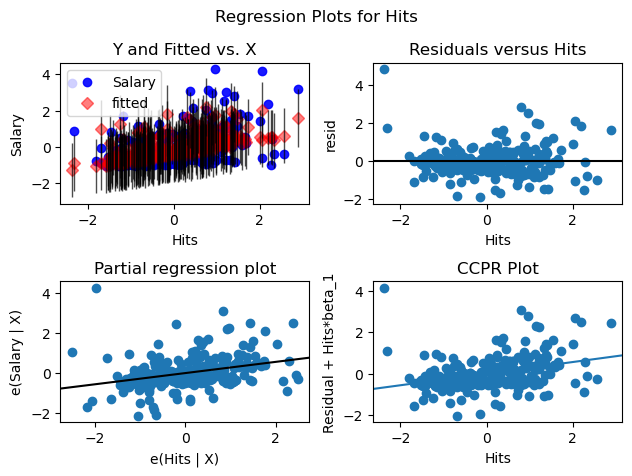

In [214]:
model = smf.ols(formula=formula, data = Hitters_d)
results = model.fit(cov_type='HC3') #robust standard errors (to heteroskedasticity)
print(results.summary())
plt.figure()
#fig =  sm.graphics.plot_regress_exog(results, "Gender[T.Male]")
fig =  sm.graphics.plot_regress_exog(results, "Hits")
fig.tight_layout(pad=1.0)

# Ridge regression

In [215]:
# Ridge regression CV uses, by default, leave-one-out cross validation. 
# In cross validation, we create train and test splits of the data.
# We fit train data, and then see the prediction adequacy with the test set
rr = RidgeCV(alphas=[1e-1, 1, 5, 10, 12, 15, 20, 50, 100]).fit(X, y) #alphas are the lambdas in the slides i.e. the strength of regularization

In [216]:
[rr.coef_, #Betas: intercept and each column in X 
 rr.score(X, y), #R^2
 rr.alpha_
]

[array([-0.10530126, -0.26031972,  0.03311013, -0.42593682,  0.45601569,
        -0.0082492 ,  0.02038369,  0.02263992,  0.21956741, -0.11593143,
        -0.14346017,  0.25156227,  0.13224473,  0.37679435,  0.23604102,
        -0.28610859,  0.17129546,  0.08013954, -0.05560287]),
 0.5327852906347805,
 5.0]

In [217]:
res = pd.concat([pd.Series(np.append("Intercept", rr.feature_names_in_)), 
                 pd.Series(np.append(rr.intercept_, rr.coef_))], axis=1)
res.columns = ["Var", "Estimate"]
res

,Var,Estimate
0,Intercept,0.170537
1,League_1_American,-0.105301
2,Division_1_West,-0.260320
3,New_League_1_American,0.033110
4,AtBat,-0.425937
5,Hits,0.456016
6,HmRun,-0.008249
7,Runs,0.020384
8,RBI,0.022640
9,Walks,0.219567


In [218]:
#Compare R^2 and shrinkage of coefficients relative to traditional OLS
formula = "Salary ~ "
for idx, f in enumerate(rr.feature_names_in_):
    if idx < (len(rr.feature_names_in_)-1):
        formula = formula + f + " + "
    else:
        formula = formula + f
model = smf.ols(formula=formula, data = Hitters_d)
results = model.fit(cov_type='HC3') #robust standard errors (to heteroskedasticity)
print(results.summary())
print("Ridge regression R^2", np.round(rr.score(X, y), 3))

                            OLS Regression Results                            
Dep. Variable:                 Salary   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     10.49
Date:                Wed, 21 Feb 2024   Prob (F-statistic):           1.91e-22
Time:                        19:34:58   Log-Likelihood:                -269.31
No. Observations:                 263   AIC:                             578.6
Df Residuals:                     243   BIC:                             650.1
Df Model:                          19                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.17

# Lasso regression

In [219]:
# Ridge regression CV uses, by default, leave-one-out cross validation. 
# In cross validation, we create train and test splits of the data.
# We fit train data, and then see the prediction adequacy with the test set
lr = LassoCV(n_alphas = 200).fit(X, y) #alphas are the lambdas in the slides i.e. the strength of regularization

In [220]:
[lr.score(X, y), #R^2
 lr.alpha_
]

[0.5352664637426618, 0.005050164429719347]

In [221]:
res = pd.concat([pd.Series(np.append("Intercept", lr.feature_names_in_)), 
                 pd.Series(np.append(rr.intercept_, lr.coef_))], axis=1)
res.columns = ["Var", "Estimate"]
res #Note how some estimates go to zero i.e. free feature selection

,Var,Estimate
0,Intercept,0.170537
1,League_1_American,-0.062154
2,Division_1_West,-0.254622
3,New_League_1_American,-0.000000
4,AtBat,-0.549108
5,Hits,0.596123
6,HmRun,0.000000
7,Runs,-0.000000
8,RBI,0.000000
9,Walks,0.238725


# Exercise (Ridge vs Lasso)

Run first the following code to setup the data. Try to understand what is doing.

In [ ]:
#Load the data ad_df_reduced.csv
ad = pd.read_csv("ad_df_reduced.csv") 
idx = np.array((ad.dtypes == "int32") | (ad.dtypes == "int64") | (ad.dtypes == "float32") | (ad.dtypes == "float64"))
non_cat_cols = ad.columns[idx]
ad.loc[:, non_cat_cols] = st.zscore(ad.loc[:, non_cat_cols]) #center numerical variables

'''
auction_id: unique id for identifying each line
timestamp: the timestamp (in seconds) of the ad impression
creative_duration: the total duration of the video that has been played
creative_id: the advertismente id
campaign_id: the advertising campaign id
advertiser_id: the advertiser id
placement_id: the id of a zone in the web page where the video was played
placement_language: the language of this zone
website_id: the corresponding website id
referer: main web domain
ua_country: the country of the user who watched the video
ua_os: the user's Operating System
ua_browser: the user's internet browser
ua_browser_version: the user's browser version
ua_device: the user's device
user_average_seconds_played: the average duration the user watched video ads in the past. It can be null if the user never watched any ad.
seconds_played: the observed time the video has been watched. This is the quantity we are trying to predict.
'''

#Design matrix (i.e. right hand variables)
idx = (ad.columns != 'Unnamed: 0') & (ad.columns != 'auction_id') & (ad.columns != 'seconds_played')
dm = dmatrix("~ 1 + " + " + ".join(ad.columns[idx]), ad) 

#In pandas format
X = pd.DataFrame(dm, columns = dm.design_info.column_names)
X.drop(columns=['Intercept'], inplace = True) #RidgeCV and LassoCV add the intercept. They are centered but still doesn't hurt to estimate an intercept
y = ad.loc[:, "seconds_played"]

1) Run a ridge regression with these alphas (regularization) \[20, 50, 55, 60, 65, 75, 100]. Which one was the best regularization value. Interpret some coefficients.
2) Run a lasso regression with n_alphas = 100. Keep features with non-zero estimates (use this criterion: Estimate>1e-10 or Estimate<-1e-10). How many were dropped relative to ridge regression? Interpret now some (non-zero) coefficients. How do they compare with the ridge regression estimates? Signs and values?

# Appendix

In [ ]:
#Tweets data set
#https://www.kaggle.com/datasets/bhavikjikadara/tweets-dataset
'''
target: the polarity of the tweet (0 = negative and 4 = positive)
ids: The id of the tweet ( 2087)
date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
flag: The query (lyx). If there is no query, then this value is NO_QUERY.
user: the user that tweeted.
text: the text of the tweet.
'''

In [177]:
# ad dataset 
#https://www.kaggle.com/datasets/karnikakapoor/video-ads-engagement-dataset
ad = pd.read_csv("C:/Users/L03552670/OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey/Cursos/Fundamentos_Marketing_Analisis_Datos/Data/ad_df.csv")
ad.dropna(inplace=True)
ad.reset_index(drop=True, inplace = True)
'''
auction_id: unique id for identifying each line
timestamp: the timestamp (in seconds) of the ad impression
creative_duration: the total duration of the video that has been played
campaign_id: the advertising campaign id
advertiser_id: the advertiser id
placement_id: the id of a zone in the web page where the video was played
placement_language: the language of this zone
website_id: the corresponding website id
referer_deep_three: the URL of the page where the video was played, truncated at its 3rd level
ua_country: the country of the user who watched the video
ua_os: the user's Operating System
ua_browser: the user's internet browser
ua_browser_version: the user's browser version
ua_device: the user's device
user_average_seconds_played: the average duration the user watched video ads in the past. It can be null if the user never watched any ad.
seconds_played: the observed time the video has been watched. This is the quantity we are trying to predict.
'''


"\nauction_id: unique id for identifying each line\ntimestamp: the timestamp (in seconds) of the ad impression\ncreative_duration: the total duration of the video that has been played\ncampaign_id: the advertising campaign id\nadvertiser_id: the advertiser id\nplacement_id: the id of a zone in the web page where the video was played\nplacement_language: the language of this zone\nwebsite_id: the corresponding website id\nreferer_deep_three: the URL of the page where the video was played, truncated at its 3rd level\nua_country: the country of the user who watched the video\nua_os: the user's Operating System\nua_browser: the user's internet browser\nua_browser_version: the user's browser version\nua_device: the user's device\nuser_average_seconds_played: the average duration the user watched video ads in the past. It can be null if the user never watched any ad.\nseconds_played: the observed time the video has been watched. This is the quantity we are trying to predict.\n"

In [178]:
'''
keywords = ['/dailymail/',
            '/washingtonpost/',
            '/independent/',
            '/lexpress/',
            '/spiegel/',
            '/lequipe/',
            '/leparisien/',
            '/chicagotribune/',
            '/salon/',
            '/corriere/']
'''
keywords = ['/washingtonpost/',
            '/lexpress/',
            '/spiegel/',
            '/corriere/']

rows_to_keep = []
cat_to_keep = []
for idx, r in enumerate(ad.referer_deep_three):
    for kw in keywords:
        #print(kw, r)
        match = re.search(kw, r)
        if match:
            rows_to_keep.append(idx)
            cat_to_keep.append(kw)
len(rows_to_keep)

92669

In [179]:
ad_reduced = ad.iloc[rows_to_keep,:]
ad_reduced.reset_index(drop=True, inplace = True)
ad_reduced.insert(ad_reduced.shape[1], "referer", cat_to_keep)

In [180]:
def num_to_cat(data, colname, catname):
    data.insert(data.shape[1], "ph", "") #place holder name (ph)
    for idx, ele in enumerate(data.loc[:, colname].unique()):
        idx_t = data.loc[:, colname] == ele
        data.loc[idx_t,"ph"] = catname + str(idx)
    data.drop(columns = colname, inplace = True)
    data.rename(columns={'ph': colname}, inplace=True) #keep the original name
    return data

ad_reduced = num_to_cat(ad_reduced, "creative_id", "CR_")
ad_reduced = num_to_cat(ad_reduced, "campaign_id", "CG_")
ad_reduced = num_to_cat(ad_reduced, "advertiser_id", "AD_")
ad_reduced = num_to_cat(ad_reduced, "placement_id", "PLACE_")
ad_reduced = num_to_cat(ad_reduced, "website_id", "WEB_")
ad_reduced = num_to_cat(ad_reduced, "ua_browser_version", "BROWSER_VER_")
ad_reduced.drop(columns = "referer_deep_three", inplace=True)
ad_reduced.dtypes

C:\Users\L03552670\AppData\Local\Temp\ipykernel_32684\315430701.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns = colname, inplace = True)
C:\Users\L03552670\AppData\Local\Temp\ipykernel_32684\315430701.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={'ph': colname}, inplace=True) #keep the original name
C:\Users\L03552670\AppData\Local\Temp\ipykernel_32684\315430701.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

auction_id                      object
timestamp                        int64
creative_duration                int64
placement_language              object
ua_country                      object
ua_os                           object
ua_browser                      object
ua_device                       object
user_average_seconds_played    float64
seconds_played                   int64
referer                         object
creative_id                     object
campaign_id                     object
advertiser_id                   object
placement_id                    object
website_id                      object
ua_browser_version              object
dtype: object

In [181]:
ad_reduced.to_csv("ad_df_reduced.csv")

EV vehicles

In [47]:
#https://www.kaggle.com/datasets/padmapiyush/global-electric-vehicle-dataset-2023?select=Global+EV+2023.csv
EV_raw = pd.read_csv('Global_EV_2023.csv') 
EV_raw.columns

Index(['region', 'category', 'parameter', 'mode', 'powertrain', 'year', 'unit',
       'value'],
      dtype='object')

In [48]:
EV = EV_raw.pivot_table(values = ["value"], columns = ["parameter"], index = ["year", "region"]).reset_index()
EV.columns = ["Year", "Region", "EV_charge_points", "EV_sales", 
             "EV_sales_share", "EV_stock", "EV_stock_share", 
             "Electricity_demand", "Oil_displace_M_barrels_day", "Oil_displace_M_liters_gasoline"]
EV.to_csv("Global_EV_Reduced.csv")
EV

,Year,Region,EV_charge_points,EV_sales,EV_sales_share,EV_stock,EV_stock_share,Electricity_demand,Oil_displace_M_barrels_day,Oil_displace_M_liters_gasoline
0,2010,Austria,NaN,2.450000e+01,0.625000,1.325000e+02,0.307800,NaN,NaN,NaN
1,2010,Belgium,NaN,2.100000e+01,0.012500,2.740000e+01,0.007900,NaN,NaN,NaN
2,2010,Brazil,NaN,3.000000e+00,0.005100,NaN,NaN,NaN,NaN,NaN
3,2010,Canada,NaN,1.000000e+00,0.001400,NaN,NaN,NaN,NaN,NaN
4,2010,China,NaN,6.929800e+02,0.072828,8.512000e+02,0.013955,6119.0,0.000284,17.5445
...,...,...,...,...,...,...,...,...,...,...
471,2030,Europe,1190000.0,1.387394e+06,45.000000,7.647312e+06,11.875000,54375.0,0.225000,13100.0000
472,2030,India,149500.0,2.047188e+05,17.500000,7.170912e+05,5.260000,6712.5,0.025337,1465.0000
473,2030,Rest of the world,570000.0,8.305000e+05,9.625000,3.503688e+06,3.028750,36575.0,0.180125,10462.5000
474,2030,USA,690000.0,1.044700e+06,36.375000,5.166375e+06,11.500000,59650.0,0.340125,19037.5000


In [58]:
EV = EV_raw.pivot_table(values = ["value"], columns = ["parameter"], index = ["region"]).reset_index()
EV.columns = ["Region", "EV_charge_points", "EV_sales", 
             "EV_sales_share", "EV_stock", "EV_stock_share", 
             "Electricity_demand", "Oil_displace_M_barrels_day", "Oil_displace_M_liters_gasoline"]
#EV.to_csv("Global_EV_Reduced.csv")
EV

,Region,EV_charge_points,EV_sales,EV_sales_share,EV_stock,EV_stock_share,Electricity_demand,Oil_displace_M_barrels_day,Oil_displace_M_liters_gasoline
0,Australia,8.667500e+02,3.753870e+03,0.955042,9.270391e+03,0.134222,NaN,NaN,NaN
1,Austria,1.087583e+03,3.270160e+03,2.599170,7.057923e+03,0.656867,NaN,NaN,NaN
2,Belgium,3.023450e+03,4.556581e+03,3.092223,8.992037e+03,0.470833,NaN,NaN,NaN
3,Brazil,3.274500e+02,9.756905e+02,0.148791,2.615037e+03,0.011609,NaN,NaN,NaN
4,Canada,3.812591e+03,8.595542e+03,1.374309,2.089674e+04,0.206905,NaN,NaN,NaN
5,Chile,7.741667e+01,1.415238e+02,0.096700,3.179048e+02,0.016623,NaN,NaN,NaN
6,China,7.379643e+05,5.247047e+05,11.541134,2.344053e+06,4.848026,18832.315217,0.076136,4572.044652
7,Denmark,2.157227e+03,2.779209e+03,4.669837,6.465722e+03,0.746429,NaN,NaN,NaN
8,EU27,NaN,7.127340e+04,2.101181,1.715411e+05,0.279429,NaN,NaN,NaN
9,Europe,4.706000e+05,3.255260e+05,8.345857,1.297147e+06,1.660079,7481.978261,0.035372,2065.980543
